In [1]:
import pandas as pd
import numpy as np
import pandasticsearch as pds
from elasticsearch import Elasticsearch

In [2]:
es = Elasticsearch(['http://es01:9200'])

In [3]:
res = es.search(index='log-generator-logrus*',body={}, size=3)

In [4]:
hits = res['hits']['hits']
for hit in hits:
    source = hit['_source']
    display(source)

{'host': 'es01',
 '@timestamp': '2020-05-27T13:40:40.278508252Z',
 'message': 'Рейс 0 задерживается на 3.808s',
 'data': {'counter': 354, 'flight_number': 0, 'status': 'INFO', 'wait': 3808},
 'level': 'INFO'}

{'host': 'es01',
 '@timestamp': '2020-05-27T13:40:44.089280837Z',
 'message': 'Рейс 0 задерживается на 3.449s',
 'data': {'counter': 355, 'flight_number': 0, 'status': 'INFO', 'wait': 3449},
 'level': 'INFO'}

{'host': 'es01',
 '@timestamp': '2020-05-27T13:40:47.540687022Z',
 'message': 'Рейс 9 задерживается на 4.973s',
 'data': {'counter': 356,
  'flight_number': 9,
  'status': 'DELAYED',
  'wait': 4973},
 'level': 'ERROR'}

In [5]:
sources = [hit['_source'] for hit in hits]
datas = [field['data'] for field in sources]

df0 = pd.DataFrame.from_records(sources)
display(df0)
df1 = pd.DataFrame.from_records(datas)
display(df1)

,host,@timestamp,message,data,level
0,es01,2020-05-27T13:40:40.278508252Z,Рейс 0 задерживается на 3.808s,"{'counter': 354, 'flight_number': 0, 'status':...",INFO
1,es01,2020-05-27T13:40:44.089280837Z,Рейс 0 задерживается на 3.449s,"{'counter': 355, 'flight_number': 0, 'status':...",INFO
2,es01,2020-05-27T13:40:47.540687022Z,Рейс 9 задерживается на 4.973s,"{'counter': 356, 'flight_number': 9, 'status':...",ERROR


,counter,flight_number,status,wait
0,354,0,INFO,3808
1,355,0,INFO,3449
2,356,9,DELAYED,4973


In [6]:
df_norm = pd.json_normalize(hits)
df_norm

,_index,_type,_id,_score,_source.host,_source.@timestamp,_source.message,_source.data.counter,_source.data.flight_number,_source.data.status,_source.data.wait,_source.level
0,log-generator-logrus-2020-05-27,_doc,_hVdVnIBZ1VibpZBFOfa,1.0,es01,2020-05-27T13:40:40.278508252Z,Рейс 0 задерживается на 3.808s,354,0,INFO,3808,INFO
1,log-generator-logrus-2020-05-27,_doc,ABVdVnIBZ1VibpZBI-i8,1.0,es01,2020-05-27T13:40:44.089280837Z,Рейс 0 задерживается на 3.449s,355,0,INFO,3449,INFO
2,log-generator-logrus-2020-05-27,_doc,AhVdVnIBZ1VibpZBMeg4,1.0,es01,2020-05-27T13:40:47.540687022Z,Рейс 9 задерживается на 4.973s,356,9,DELAYED,4973,ERROR


# SQL запросы
Используя официальный драйвер

In [7]:
def sqlresult_to_dataframe(sql_res):
    rows = sql_res['rows']
    cols = sql_res['columns']
    col_names = [c['name'] for c in cols]
    return pd.DataFrame.from_records(rows,columns=col_names)
    
sql_query = {'query':'SELECT * FROM "log-generator-logrus*" LIMIT 3'}
sql_res = es.sql.query(sql_query)
sqlresult_to_dataframe(sql_res)


,@timestamp,data.counter,data.flight_number,data.status,data.wait,host,level,message
0,2020-05-27T13:40:40.278Z,354,0,INFO,3808,es01,INFO,Рейс 0 задерживается на 3.808s
1,2020-05-28T22:05:02.259Z,12701,2,INFO,3674,es01,INFO,Рейс 2 задерживается на 3.674s
2,2020-05-29T00:00:00.865Z,15473,4,INFO,456,es01,INFO,Рейс 4 задерживается на 456ms


# Pandasticsearch

In [8]:
# from pandasticsearch import Select
pds.Select.from_dict(res).to_pandas()


,_index,_type,_id,_score,host,@timestamp,message,data.counter,data.flight_number,data.status,data.wait,level
0,log-generator-logrus-2020-05-27,_doc,_hVdVnIBZ1VibpZBFOfa,1.0,es01,2020-05-27T13:40:40.278508252Z,Рейс 0 задерживается на 3.808s,354,0,INFO,3808,INFO
1,log-generator-logrus-2020-05-27,_doc,ABVdVnIBZ1VibpZBI-i8,1.0,es01,2020-05-27T13:40:44.089280837Z,Рейс 0 задерживается на 3.449s,355,0,INFO,3449,INFO
2,log-generator-logrus-2020-05-27,_doc,AhVdVnIBZ1VibpZBMeg4,1.0,es01,2020-05-27T13:40:47.540687022Z,Рейс 9 задерживается на 4.973s,356,9,DELAYED,4973,ERROR


,interval,count
0,2020-06-02T23:51:00.000Z,5
1,2020-06-02T23:50:30.000Z,11
2,2020-06-02T23:50:00.000Z,14
3,2020-06-02T23:49:30.000Z,12
4,2020-06-02T23:49:00.000Z,10
5,2020-06-02T23:48:30.000Z,13
6,2020-06-02T23:48:00.000Z,14
7,2020-06-02T23:47:30.000Z,13
8,2020-06-02T23:47:00.000Z,10
9,2020-06-02T23:46:30.000Z,8


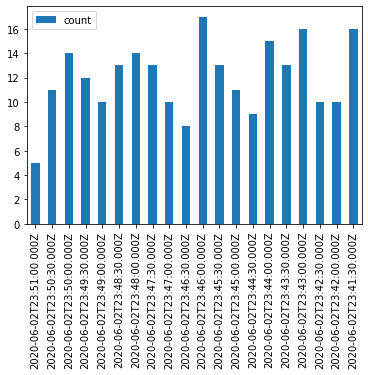

In [17]:
q = '''
  SELECT HISTOGRAM("@timestamp", INTERVAL 30 SECOND) as interval, 
  count(*) as count
  FROM "log-generator-logrus*"
  GROUP by interval
  ORDER BY interval DESC
  LIMIT 20
'''
client = pds.RestClient('http://es01:9200', '_sql')
r = client.post({'query':q})
df = sqlresult_to_dataframe(r)
display(df)
# ax = df.plot.bar()


# https://stackoverflow.com/questions/49961169/show-categorical-x-axis-values-when-making-line-plot-from-pandas-series-in-matpl

ax = df.plot.bar()
ax.set_xticks(df.index)
ax.set_xticklabels(df.interval, rotation=90)
ax

In [11]:
import plotly.express as px

In [58]:
r = client.post({'query':q})
df = sqlresult_to_dataframe(r)


In [59]:
fig = px.bar(df, x='interval',y='count', text='count')
fig.update_traces(textposition='outside')
fig.update_layout(title_text='Количество записей в лог каждые 30 сек')
fig.show()